# Synthetix Perps V2 Funding

This project provides a Python based sample implementation of the new funding model described in [SIP-279](https://sips.synthetix.io/sips/sip-279/) for Perps V2. The new funding model aims to optimise for a perfectly balanced skew. To recap the basics,

1. A perps market is a Synth/sUSD pair e.g. sETH/sUSD
1. A market skew is present when longs and shorts don't balance out e.g. 1M short, 2M long has a 1M long skew
1. When a skew is present, the skewed direction pays the opposite defined by a 'funding rate' e.g. 1M longs pay shorts. This is meant to incentivise arbers to short on Synthetix and long on another exchange, reducing skew back to equilibrium

The current mainnet implementation of [SIP-80](https://sips.synthetix.io/sips/sip-80/) poses two problems:

1. There is no financial incentive to perform the arb as funding rates are calculated instantaneously. In the example above, a short to bring skew back to 0 will also result in a 0 funding rate. The arber makes no money
1. Funding rate volatility. A funding rate that fluctuates too frequently is not attractive for traders

The new funding model in SIP-279 solves this by introducing a floating funding rate of sorts. The basic idea is as follows:

1. As long as the market skew is not at equilibrium, increase the funding in the same direction. As some point, there will be enough market participants willing to bring it back. If there's free money on the table, and you had alpha to take advantage, why not?
1. If/when a market skew is at equilibrium stop changing the funding rate. This is the floating funding rate. It doesn't instantaneously drop to 0, keeping the arbers on the exchange to maintain skew. We can denote this as the fair market funding rate.
1. If the skew drifts past equilibrium into the other direction, the funding rate hence increases in the opposite direction.

# Funding Velocity

This defines how quickly funding rate increases as long as the skew is not at equilibrium. We define 2 static but configurable variables

- `fundingVelocityScale` - A value in USD to fractionalise the skew e.g. 1M / 10M = 0.1
- `maxFundingVelocity` - The maximum percentage in funding per day e.g. 2.5%

Note that funding rate increases relative to the skew, fractionalised by `fundingVelocityScale`.

In [1]:
FUNDING_VELOCITY_SCALE = 10_000_000 # 10M USD
MAX_FUNDING_VELOCITY = 0.025 # 2.5%
ASSET_PRICE = 1500 # 1500 USD


def calc_funding_rate_velocity(skew: float, skew_scale_usd: float, max_funding_pct: float, price: float) -> float:
    """Calculates the daily funding rate given current market conditions.

    :param float skew: Market skew denoted by size
    :param float skew_scale_usd: Maximum funding velocity scale denoted in USD
    :param float max_funding_pct: Maximum percentage increase in funding per day
    :param float price: Price of the underlying market Synth e.g. sETH

    """
    return (skew * price) / skew_scale_usd * max_funding_pct

# Examples
print(
    calc_funding_rate_velocity(
        -1000, FUNDING_VELOCITY_SCALE, MAX_FUNDING_VELOCITY, ASSET_PRICE
    )
)
print(
    calc_funding_rate_velocity(
        10_000, FUNDING_VELOCITY_SCALE, MAX_FUNDING_VELOCITY, ASSET_PRICE
    )
)
print(
    calc_funding_rate_velocity(
        FUNDING_VELOCITY_SCALE / ASSET_PRICE,
        FUNDING_VELOCITY_SCALE,
        MAX_FUNDING_VELOCITY,
        ASSET_PRICE,
    )
)  # max rate velocity

-0.00375
0.037500000000000006
0.025


# Example Simulation

We can simulate this behaviour to see how the funding rate can float. Let's start by defining a simple subset of a `Position` dataclass to represent positions on-chain for the purposes of this simulation. We also define a `Market` dataclass to isolate 

In [38]:
from dataclasses import dataclass
from typing import List, Type, Optional, Union


SECONDS_IN_DAY: int = 86400

@dataclass
class Position:
    size: float


@dataclass
class Market:
    positions: List[Type[Position]]
    price: float = 0
    last_modified_at: int = 0

    # Cached values on every market modification to avoid computing against `positions` every time.
    size: float = 0
    skew: float = 0
    funding_rate: float = 0
    funding_accrued: float = 0

    # Static but configurable variables
    skew_scale_usd: float = 0
    max_funding_pct: float = 0

    def modify_position(self, t: int, size_usd: Optional[float]) -> None:
        # How much time has passed?
        t_delta = t - self.last_modified_at 

        # Update funding rate.
        self.funding_rate += t_delta * (self.funding_rate_velocity() / SECONDS_IN_DAY)
        self.last_modified_at = t

        # No position was added/removed. We're just touching to update cache.
        if size_usd:
            # Update position, size, and skew.
            size = size_usd / self.price
            position = Position(size)
            self.positions.append(position)
            self.size += abs(size)
            self.skew += size

        # Update accrued funding.
        self.funding_accrued += (t_delta * (self.funding_rate / SECONDS_IN_DAY)) * self.size * self.price

    def funding_rate_velocity(self) -> float:
        return (self.skew * self.price) / self.skew_scale_usd * self.max_funding_pct

In [ ]:
import sys
!{sys.executable} -m pip install matplotlib pandas

In [39]:
import pandas as pd
from IPython.display import display


def ppint_sim_events(events) -> None:
    df = pd.DataFrame(events)
    display(df)


def sim(market, intervals, events):
    for interval in intervals:
        market.modify_position(interval['t'], interval['size_usd'])
        events.append({
            't': market.last_modified_at,
            'size': market.size,
            'skew': market.skew,
            'funding_rate': market.funding_rate,
            'funding_velocity': market.funding_rate_velocity(),
            'funding_accrued': market.funding_accrued,
        })
    return events


def simulation_01(price=1000):
    """Concrete example with pre-defined timeseries (with static price)."""
    intervals = [
        {'t': 1000, 'size_usd': 1_000_000},
        {'t': 30_000, 'size_usd': 2_000_000},
        {'t': 50_000, 'size_usd': -3_000_000},
        {'t': 100_000, 'size_usd': None},
        {'t': 150_000, 'size_usd': -2_000_000},
        {'t': 200_000, 'size_usd': 2_000_000},
        {'t': 300_000, 'size_usd': None},
        {'t': 400_000, 'size_usd': None},
    ]

    # Initial market conditions. We start with a perfectly balanced skew with 2M in both directions.
    market = Market(
        positions=[],
        last_modified_at=0,
        price=price,
        skew_scale_usd=FUNDING_VELOCITY_SCALE,
        max_funding_pct=MAX_FUNDING_VELOCITY,
    )

    market.modify_position(0, -2_000_000)
    market.modify_position(0, 2_000_000)

    events = [
        {
            't': 0,
            'size': 2000,
            'skew': 0,
            'funding_rate': 0,
            'funding_velocity': market.funding_rate_velocity(),
            'funding_accrued': 0,
        }
    ]
    return sim(market, intervals, events)


sim_01_res = simulation_01()
ppint_sim_events(sim_01_res)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

## Sim 01 - Observations

- Funding rate is calculated based on market conditions between `t - 1` and `t`. That is, we don't see the effects of the new position upon modifying the market. We only see it in subsequent touches.
- The funding rate can float at a 'fair market funding rate' when the skew is at 0
- `funding_accrued (total in usd)` is the overall amount of funding accrued. We see that after the funding rate shifts, it begins to reduce.
  - We can look at this to get a gut feel gauge on whether the market is usually long or short. However, since accrual is largely dependent on time, this isn't a very accurate representation.

## Sim 01a - Funding Rate

At 100k -> 200k, it's hard to see how the funding rate gradually changes. Let's take a deeper look.

In [36]:
def simulation_01a(step=5000, price=1000):
    intervals = [
        {'t': 1000, 'size_usd': 1_000_000},
        {'t': 30_000, 'size_usd': 2_000_000},
        {'t': 50_000, 'size_usd': -3_000_000},
        {'t': 100_000, 'size_usd': None},
        {'t': 150_000, 'size_usd': -2_000_000},
    ]
    intervals += [{'t': t, 'size_usd': None} for t in range(160_000, 190_000, step)]
    intervals += [
        {'t': 200_000, 'size_usd': 2_000_000},
        {'t': 250_000, 'size_usd': None},
        {'t': 400_000, 'size_usd': None},
    ]

    # Initial market conditions. We start with a perfectly balanced skew with 2M in both directions.
    market = Market(
        positions=[],
        last_modified_at=0,
        price=price,
        skew_scale_usd=FUNDING_VELOCITY_SCALE,
        max_funding_pct=MAX_FUNDING_VELOCITY,
    )

    market.modify_position(0, -2_000_000)
    market.modify_position(0, 2_000_000)

    events = [
        {
            't': 0,
            'size': 2000,
            'skew': 0,
            'funding_rate': 0,
            'funding_velocity': market.funding_rate_velocity(),
            'funding_accrued': 0,
        }
    ]
    return sim(market, intervals, events)

sim_01a_res = simulation_01a()
ppint_sim_events(sim_01a_res)

,t,size,skew,funding_rate,funding_velocity,funding_accrued
0,0,2000.0,0.0,0.000000,0.0000,0.000000
1,1000,5000.0,1000.0,0.000000,0.0025,0.000000
2,30000,7000.0,3000.0,0.000839,0.0075,1971.544389
3,50000,10000.0,0.0,0.002575,0.0000,7932.728374
4,100000,10000.0,0.0,0.002575,0.0000,7932.728374
5,150000,12000.0,-2000.0,0.002575,-0.0050,25816.280328
6,160000,12000.0,-2000.0,0.001997,-0.0050,25816.280328
7,165000,12000.0,-2000.0,0.001707,-0.0050,25816.280328
8,170000,12000.0,-2000.0,0.001418,-0.0050,25816.280328
9,175000,12000.0,-2000.0,0.001128,-0.0050,25816.280328


We see that at 150k, with a -2M skew, funding rate slowly moves in the negative direction at a constant velocity (as this is proportional to the skew and the skew never changes). Once the skew is balanced, velocity drops to 0 and funding rates stops moving. We can visualise the rate of change at a smaller scale:

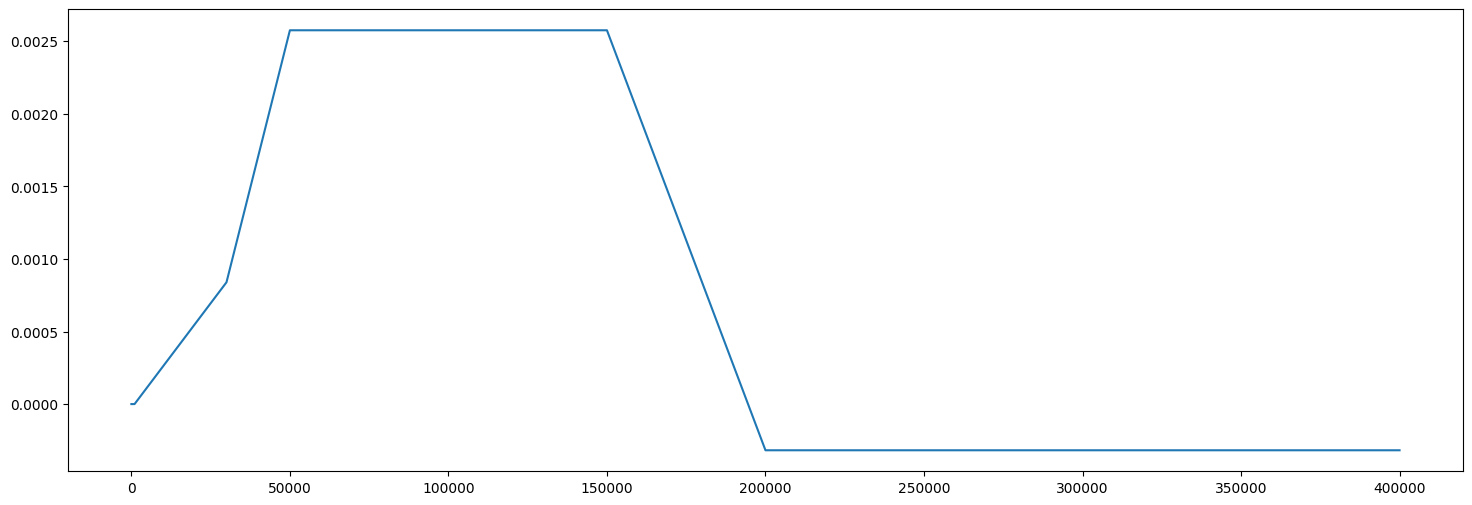

In [37]:
import matplotlib.pyplot as plt

sim_01a_res = simulation_01a(step=1000)

plt.subplots(figsize=(18, 6))
plt.plot(
    [x['t'] for x in sim_01a_res],
    [y['funding_rate'] for y in sim_01a_res],
)
plt.show()

## Accrued Funding

With the above, we see that the market has accrued funding. However, it makes more sense to see how much funding one position thoughtout its lifetime (with the same conditions as the above simulation) receives. Imagine we had a 1M long position since the market genesis. How much funding would we have accrued by the end of the sim?